In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


naver.me/5s9YNMcH  --> data-02-stock_daily.csv
Open(시작가), High(최고가), Low(최저가), Vol(거래량), Close(종가)

In [5]:
import numpy as np
xy = np.loadtxt('/content/gdrive/My Drive/Colab Notebooks/
data-02-stock_daily.csv', delimiter=",")

In [7]:
xy[:2]

array([[8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02]])

In [10]:
#train, test split
seq_length = 7
train_size = int(len(xy)*0.7)
train_set = xy[:train_size]
test_set = xy[train_size - seq_length:]
print(train_set.shape, test_set.shape)

(512, 5) (227, 5)


In [13]:
def minmax_scaler(data):
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0)-np.min(data,0)
  return numerator / (denominator + 1e-7)

In [14]:
#scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

In [15]:
train_set[:3]

array([[0.97125436, 0.97337226, 1.        , 0.06773081, 0.98742313],
       [0.95353593, 0.95651845, 0.978622  , 0.10064206, 0.97616367],
       [0.94382833, 0.94502159, 0.97008016, 0.07092699, 0.96390035]])

In [27]:
def build_dataset(time_series_data, seq_length):
  data_X = []; data_y = []
  for i in range(0, len(time_series_data)-seq_length):
    x_ = time_series_data[i: i + seq_length, :]
    y_ = time_series_data[i+seq_length, [-1]]
    data_X.append(x_); data_y.append(y_)
  return np.array(data_X), np.array(data_y)


In [28]:
train_X, train_y = build_dataset(train_set, seq_length)
test_X, test_y = build_dataset(test_set, seq_length)


In [32]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [33]:
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [34]:
train_X_tensor = torch.FloatTensor(train_X)
train_y_tensor = torch.FloatTensor(train_y)
test_X_tensor = torch.FloatTensor(test_X)
test_y_tensor = torch.FloatTensor(test_y)

In [35]:
class Net(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, layers):
    super(Net, self).__init__()
    self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, 
                             batch_first=True)
    self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

  def forward(self, x):
    x, _status = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [36]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [37]:
# training!
for i in range(iterations):
  optimizer.zero_grad()
  outputs = net(train_X_tensor)
  loss = criterion(outputs, train_y_tensor)
  loss.backward()
  optimizer.step()
  print(i, loss.item())

0 0.323285847902298
1 0.252380907535553
2 0.19305264949798584
3 0.14350390434265137
4 0.10289836674928665
5 0.07115103304386139
6 0.04864220321178436
7 0.035755615681409836
8 0.03220793977379799
9 0.03615980222821236
10 0.04372021555900574
11 0.05030609667301178
12 0.053085584193468094
13 0.05161869153380394
14 0.046934716403484344
15 0.04055734723806381
16 0.03392542153596878
17 0.02812269888818264
18 0.023787379264831543
19 0.02112375758588314
20 0.019976604729890823
21 0.01994234509766102
22 0.02049354836344719
23 0.02109740860760212
24 0.021313685923814774
25 0.020861951634287834
26 0.019652731716632843
27 0.01778183877468109
28 0.015491258352994919
29 0.013104261830449104
30 0.01094614528119564
31 0.009265937842428684
32 0.008177508600056171
33 0.00763683021068573
34 0.007463966030627489
35 0.007404856383800507
36 0.007214161567389965
37 0.006732462905347347
38 0.005933240056037903
39 0.004925924353301525
40 0.003915106412023306
41 0.003126709023490548
42 0.002719542011618614
43 0

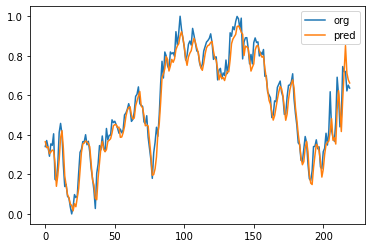

In [39]:
plt.plot(test_y)
plt.plot(net(test_X_tensor).data.numpy())
plt.legend(['org', 'pred'])
plt.show()